# Demo 7 (Week 8): Sentiment Analysis (TF‑IDF + Logistic Regression)
_Generated: 2025-10-01 14:10_

## 1) Problem Statement
We tackle a **binary sentiment analysis** task: classify text reviews as **positive** or **negative**.

**Inputs:** Raw text reviews.  
**Output:** A binary label (`1 = positive`, `0 = negative`).

We'll use a classic and very strong baseline:
- **Text vectorization:** TF‑IDF (word-level)  
- **Classifier:** Logistic Regression

Why this combo? It's fast, robust, and often competitive with heavier models for bag‑of‑words style tasks.

## 2) Environment & Imports

In [1]:
import sys, os, random, math
import numpy as np
import matplotlib.pyplot as plt

# Core ML
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
)
from sklearn.utils import shuffle

# Persistence
import joblib

print("Python:", sys.version.split()[0])
try:
    import sklearn
    print("scikit-learn:", sklearn.__version__)
except Exception as e:
    print("scikit-learn not found:", e)

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

Python: 3.10.11
scikit-learn: 1.3.0


## 3) Load Data (with fallbacks)
We try in order:
1. **NLTK movie_reviews** corpus (requires `nltk` and an internet download once).
2. **Keras IMDB** (we reconstruct text from indices; requires `tensorflow` and a one-time download).
3. **Built-in tiny toy dataset** (always works offline; enough to demonstrate the pipeline).

In [2]:
def load_data_with_fallbacks():
    texts, labels = None, None

    # ---- Option A: NLTK movie_reviews ----
    try:
        import nltk
        nltk.download('movie_reviews', quiet=True)
        from nltk.corpus import movie_reviews
        fileids = movie_reviews.fileids()
        texts = [" ".join(movie_reviews.words(fid)) for fid in fileids]
        labels = [1 if movie_reviews.categories(fid)[0] == "pos" else 0 for fid in fileids]
        print(f"Loaded NLTK movie_reviews: {len(texts)} docs.")
        return texts, np.array(labels, dtype=int)
    except Exception as e:
        print("[Info] NLTK movie_reviews unavailable:", e)

    # ---- Option B: Keras IMDB ----
    try:
        import tensorflow as tf
        from tensorflow.keras.datasets import imdb

        # Load integer-encoded sequences
        (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=20000)
        word_index = imdb.get_word_index()
        inv_index = {v+3: k for k, v in word_index.items()}  # offset by 3
        inv_index[0], inv_index[1], inv_index[2], inv_index[3] = "<PAD>", "<START>", "<UNK>", "<UNUSED>"

        def seq_to_text(seq):
            return " ".join(inv_index.get(i, "<UNK>") for i in seq)

        texts = [seq_to_text(s) for s in np.concatenate([x_train, x_test])]
        labels = np.concatenate([y_train, y_test])
        print(f"Loaded Keras IMDB (reconstructed): {len(texts)} docs.")
        return texts, labels.astype(int)
    except Exception as e:
        print("[Info] Keras IMDB unavailable:", e)

    # ---- Option C: Tiny built-in toy dataset ----
    toy_pos = [
        "I loved this movie, it was fantastic and heartwarming!",
        "Absolutely brilliant, a masterpiece I would watch again.",
        "Great acting and a compelling story, highly recommended.",
        "This was enjoyable and fun, I smiled the whole time.",
        "Wonderful film with excellent pacing and characters.",
        "Incredible! Exceeded my expectations in every way.",
        "I was moved to tears by the beautiful ending.",
        "Charming and delightful, the audience applauded.",
        "A touching, uplifting story with memorable scenes.",
        "Simply great! The direction and music were perfect."
    ]
    toy_neg = [
        "I hated this movie, it was boring and predictable.",
        "Terrible acting and a weak plot, not worth my time.",
        "Awful experience, I regret watching this film.",
        "Disappointing and dull, I nearly fell asleep.",
        "Poorly written and badly directed, a complete mess.",
        "This was painful to watch; I left halfway through.",
        "Uninspired, cliche, and far too long for the content.",
        "A waste of time; I wouldn't recommend it to anyone.",
        "Clumsy editing and wooden performances throughout.",
        "One of the worst films I've seen this year."
    ]
    texts = toy_pos + toy_neg
    labels = np.array([1]*len(toy_pos) + [0]*len(toy_neg), dtype=int)
    texts, labels = shuffle(texts, labels, random_state=SEED)
    print(f"Using tiny built-in dataset: {len(texts)} docs (for demo only).")
    return texts, labels

texts, labels = load_data_with_fallbacks()
print("Class balance:", {c:int((labels==c).sum()) for c in np.unique(labels)})

[Info] NLTK movie_reviews unavailable: No module named 'nltk'

1641221/1641221 [==============================] - 1s 1us/step
Loaded Keras IMDB (reconstructed): 50000 docs.
Class balance: {0: 25000, 1: 25000}


## 4) Train/Validation/Test Split
We hold out a test set for final evaluation and a small validation set for quick checks.

In [3]:
X_train, X_temp, y_train, y_temp = train_test_split(
    texts, labels, test_size=0.2, random_state=SEED, stratify=labels
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp
)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 40000, Val: 5000, Test: 5000


## 5) TF‑IDF + Logistic Regression Pipeline
We limit vocabulary to a reasonable size, remove English stopwords, and use unigrams + bigrams.

In [4]:
pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        stop_words="english",
        ngram_range=(1,2),
        max_features=30000,
        dtype=np.float32
    )),
    ("logreg", LogisticRegression(
        max_iter=1000,
        C=2.0,
        class_weight="balanced",
        random_state=SEED,
        n_jobs=-1 if hasattr(LogisticRegression, "n_jobs") else None
    ))
])

pipe.fit(X_train, y_train)
val_pred = pipe.predict(X_val)
val_acc = accuracy_score(y_val, val_pred)
print("Validation accuracy:", round(val_acc, 4))

Validation accuracy: 0.895


## 6) Final Evaluation on Test Set
We report accuracy, precision/recall/F1, confusion matrix, and ROC‑AUC.

Test accuracy: 0.8986

Classification report:
               precision    recall  f1-score   support

           0     0.9052    0.8904    0.8978      2500
           1     0.8922    0.9068    0.8994      2500

    accuracy                         0.8986      5000
   macro avg     0.8987    0.8986    0.8986      5000
weighted avg     0.8987    0.8986    0.8986      5000

Confusion matrix:
 [[2226  274]
 [ 233 2267]]
ROC-AUC: 0.962


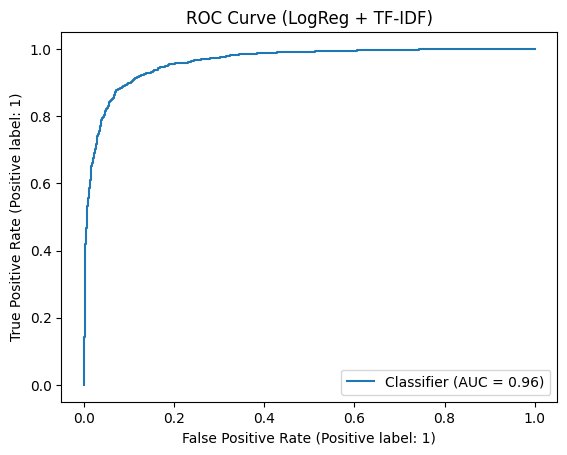

In [5]:
test_pred = pipe.predict(X_test)
test_proba = pipe.predict_proba(X_test)[:,1] if hasattr(pipe, "predict_proba") else None

print("Test accuracy:", round(accuracy_score(y_test, test_pred), 4))
print("\nClassification report:\n", classification_report(y_test, test_pred, digits=4))

cm = confusion_matrix(y_test, test_pred)
print("Confusion matrix:\n", cm)

if test_proba is not None:
    try:
        auc = roc_auc_score(y_test, test_proba)
        print("ROC-AUC:", round(auc, 4))
        RocCurveDisplay.from_predictions(y_test, test_proba)
        plt.title("ROC Curve (LogReg + TF-IDF)")
        plt.show()
    except Exception as e:
        print("ROC-AUC/plot error:", e)

## 7) Save the Model
We persist the entire pipeline with `joblib` so it includes both the TF‑IDF vectorizer and the classifier.

In [6]:
MODEL_PATH = "demo7_sentiment_logreg_tfidf.joblib"
joblib.dump(pipe, MODEL_PATH)
print("Saved pipeline to:", MODEL_PATH)

Saved pipeline to: demo7_sentiment_logreg_tfidf.joblib


## 8) Inference: Try Your Own Sentences
Edit the list below to test your own text. The pipeline handles preprocessing internally.

In [7]:
examples = [
    "I absolutely loved this! A wonderful film with great performances.",
    "This was terrible. I am never watching it again.",
    "Mediocre at best; some parts were good but overall disappointing."
]

loaded = joblib.load("demo7_sentiment_logreg_tfidf.joblib")
preds = loaded.predict(examples)
probs = loaded.predict_proba(examples)[:,1] if hasattr(loaded, "predict_proba") else None

for i, txt in enumerate(examples):
    label = int(preds[i])
    conf = f" (p_pos={probs[i]:.3f})" if probs is not None else ""
    print(f"- '{txt[:60]}{'...' if len(txt)>60 else ''}' -> {label}{conf}")

- 'I absolutely loved this! A wonderful film with great perform...' -> 1 (p_pos=0.999)
- 'This was terrible. I am never watching it again.' -> 0 (p_pos=0.001)
- 'Mediocre at best; some parts were good but overall disappoin...' -> 0 (p_pos=0.174)


## 9) (Optional) Quick Hyperparameter Sweep
Uncomment to run a tiny grid search. Keep it small for quick runs.

In [9]:
from sklearn.model_selection import GridSearchCV
tiny_grid = {
    "tfidf__ngram_range": [(1,1), (1,2)],
    "logreg__C": [0.5, 1.0, 2.0, 4.0],
}
gs = GridSearchCV(pipe, tiny_grid, cv=3, n_jobs=-1, scoring="f1")
gs.fit(X_train, y_train)
print("Best params:", gs.best_params_)
print("Best CV score (f1):", round(gs.best_score_, 4))
print("Val score:", round(accuracy_score(y_val, gs.predict(X_val)), 4))

Best params: {'logreg__C': 4.0, 'tfidf__ngram_range': (1, 2)}
Best CV score (f1): 0.8988
Val score: 0.896
